# Context Encoder

Autor: Klaudia Palak

Implementacja metody Context Encoder dla datasetu Paris Street View. Zniekształcenie użyte to bloki centralne.

# Libraries

In [79]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

# uncomment dashes below if you use local GPU
import dash
import dash_core_components as dcc
import dash_html_components as html

from IPython.display import clear_output 

# Settings

In [2]:
# number of epochs of training
n_epochs = 1000 # docelowo powinno być 100 000
# size of the batches
batch_size = 64
# adam: learning rate
lr = 0.001
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 128
# size of random mask
mask_size = 64
# number of image channels
channels = 3
# interval between image sampling
sample_interval = 100
# overlapPred - We use a higher learning rate for context encoder (10 times) 
# to that of adversarial discriminator. To further emphasize the consistency 
# of prediction with the context, we predict a slightly larger patch that 
# overlaps with the context (by 7px). During training, we use higher weight 
# (10×) for the reconstruction loss in this overlapping region.
# Additionally, in final version on github there is overlapPred=4 during the training
overlapPred = 4
overlapL2Weight = 10
# weight for L2 loss
wtl2 = 0.999 # This value is used in the article

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("test_images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [45]:
# setting whether to train the network from the beginning or using a pre-train model
load_pretrained_models = False
# path to pre-train model
pre_trained_gen_model = "/content/saved_models/generator_epoch_15.pth"
pre_trained_disc_model = "/content/saved_models/discriminator_epoch_15.pth"
# path to pre-train model for test data
pre_trained_model_test_data = "./saved_models/generator_epoch_120.pth"

# Dataset


In [ ]:
# Mount Google Drive - if you use Google GPU
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Unzip Paris Street View dataset - if you use Google GPU
!unzip "/content/gdrive/MyDrive/Paris_street_view/train/paris_train_original.zip"
!unzip "/content/gdrive/MyDrive/Paris_street_view/val/paris_eval.zip"
clear_output()

In [ ]:
# Unzip Paris Street View dataset - if you use Google GPU
train_dataset = "/content/paris_train_original"
test_dataset = "/content/paris_eval_gt"
corrupted_test_dataset = "/content/paris_eval_corrupted"

In [9]:
# paths to dataset - if you use local GPU 
train_dataset = "./Magisterka/Datasets/Paris_street_view/paris_train_original/paris_train_original"
test_dataset = "./Magisterka/Datasets/Paris_street_view/paris_eval/paris_eval_gt"
corrupted_test_dataset = "./Magisterka/Datasets/Paris_street_view/paris_eval/paris_eval_corrupted"

In [10]:
# Define dataset class
class ImageDataset(Dataset):
    def __init__(self, transforms_=None, img_size=128, mask_size=64, mode="train"):
        # transforms.Compose - composes several transforms together.
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = glob.glob("%s/*.JPG" % train_dataset) if mode == "train" else glob.glob("%s/*.png" % test_dataset)

    # Jakiś pomysł na randomowe wprowadzenie zniekształceń
    # def apply_random_mask(self, img):
    #     """Randomly masks image"""
    #     y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
    #     y2, x2 = y1 + self.mask_size, x1 + self.mask_size
    #     masked_part = img[:, y1:y2, x1:x2]
    #     masked_img = img.clone()
    #     masked_img[:, y1:y2, x1:x2] = 1

    #     return masked_img, masked_part

    def apply_center_mask_with_overlapPred(self, img):
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, (i + overlapPred) : (i + self.mask_size - overlapPred), (i + overlapPred) : (i + self.mask_size - overlapPred)] = 1
        masked_part = img[:, i : i + self.mask_size, i : i + self.mask_size]

        return masked_img, masked_part, i

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate of the mask
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1
        masked_part = img[:, i : i + self.mask_size, i : i + self.mask_size]

        return masked_img, masked_part, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform mask with overlapPred
            masked_img, masked_part, i = self.apply_center_mask_with_overlapPred(img)
        else:
            # For test data mask the center of the image
            masked_img, masked_part, i = self.apply_center_mask(img)

        return img, masked_img, masked_part, i

    def __len__(self):
        return len(self.files)

In [24]:
# Get Dataloaders
transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.CenterCrop(img_size),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

test_dataloader = DataLoader(
    ImageDataset(transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)

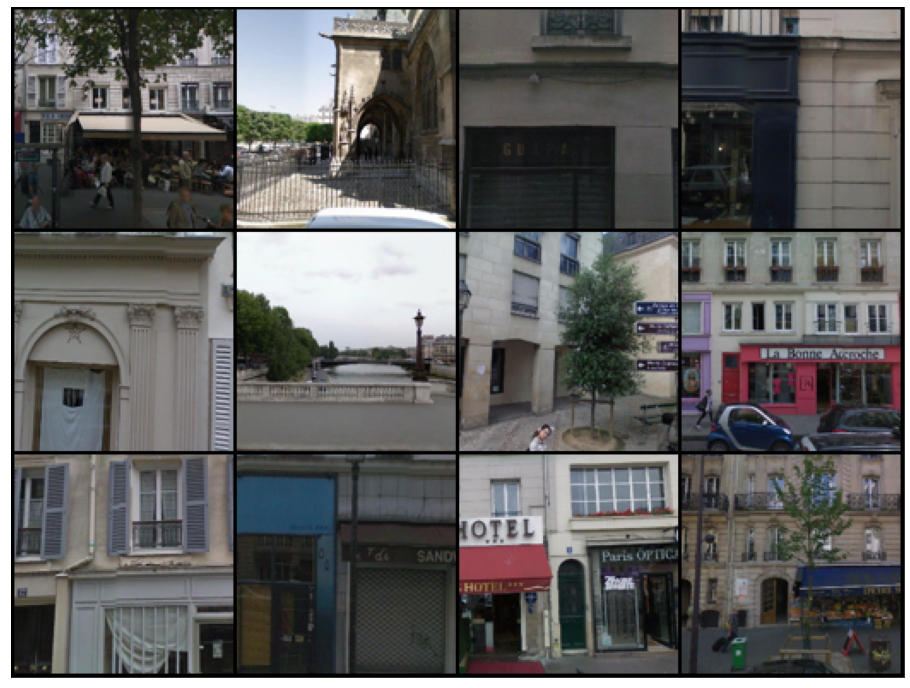

In [25]:
# Data visualization
def imshow(img):
    img = img / 2.0 + 0.5
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((img), nrow=4).permute(1, 2, 0))

dataiter = iter(test_dataloader)
images = dataiter.next()

imshow(images[0])

# Model

## Generator Model

In [26]:
class Generator(nn.Module):
  def __init__(self, channels_number=3, encoder_filters_number=64, nBottleneck=4000, generator_filters_number=64):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # Parameters for Conv2d layer in order: in_channels, out_channels, kernel_size, stride, padding; also you can add bias = True/False
        # Explanation: There is no bias parameter in the original code, so I assume that for Conv2d layer is default -> bias = True

        # down-convolutional
        # input is (channels_number) x 128 x 128
        nn.Conv2d(channels_number, encoder_filters_number, 4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(encoder_filters_number, encoder_filters_number, 4, stride=2, padding=1),
        nn.BatchNorm2d(encoder_filters_number),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(encoder_filters_number, encoder_filters_number*2, 4, stride=2, padding=1),
        nn.BatchNorm2d(encoder_filters_number*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(encoder_filters_number*2, encoder_filters_number*4, 4, stride=2, padding=1),
        nn.BatchNorm2d(encoder_filters_number*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(encoder_filters_number*4, encoder_filters_number*8, 4, stride=2, padding=1),
        nn.BatchNorm2d(encoder_filters_number*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(encoder_filters_number*8, nBottleneck, 4),
        nn.BatchNorm2d(nBottleneck),
        nn.LeakyReLU(0.2, inplace=True),

        # Bottleneck as an input go into a convolution
        # up-convolutional
        nn.ConvTranspose2d(nBottleneck, generator_filters_number*8, 4, stride=1, padding=0),
        nn.BatchNorm2d(generator_filters_number * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_filters_number * 8, generator_filters_number * 4, 4, stride=2, padding=1),
        nn.BatchNorm2d(generator_filters_number * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_filters_number * 4, generator_filters_number * 2, 4, stride=2, padding=1),
        nn.BatchNorm2d(generator_filters_number * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_filters_number * 2, generator_filters_number, 4, stride=2, padding=1),
        nn.BatchNorm2d(generator_filters_number),
        nn.ReLU(True),

        nn.ConvTranspose2d(generator_filters_number, channels_number, 4, stride=2, padding=1),
        nn.Tanh()

    )

  def forward(self, input):
    return self.model(input)


## Discriminator Model

In [27]:
class Discriminator(nn.Module):
    def __init__(self, channels_number=3, discriminator_filters_number=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (channels_number) x 64 x 64
            nn.Conv2d(channels_number, discriminator_filters_number, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(discriminator_filters_number, discriminator_filters_number * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(discriminator_filters_number * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(discriminator_filters_number * 2, discriminator_filters_number * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(discriminator_filters_number * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(discriminator_filters_number * 4, discriminator_filters_number * 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(discriminator_filters_number * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(discriminator_filters_number * 8, 1, 4, stride=1, padding=0),
            # sigmoid to determine whether an image is real or fake
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.model(input)
        # return output.view(-1, 1)
        return output


# Training

In [28]:
# Set of weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [29]:
# Loss function
criterion = nn.BCELoss()

# Initialize Generator and Discriminator
generator = Generator(channels_number=channels)
discriminator = Discriminator(channels_number=channels)

In [30]:
print(generator)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Lea

In [31]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


In [32]:
print(cuda)

True


In [33]:
# Establish convention size for inputs and labels
input_real = torch.FloatTensor(batch_size, channels, img_size, img_size)
input_cropped = torch.FloatTensor(batch_size, channels, img_size, img_size)
label = torch.FloatTensor(batch_size)
real_center = torch.FloatTensor(batch_size, channels, img_size // 2, img_size // 2)

# Setting the initial values for the best epoch and for the smallest error value
greatest_predictor_epoch = None
min_gen_loss = math.inf

In [35]:
# Load pretrained models or train NN from the beggining
if load_pretrained_models:
    generator.load_state_dict(torch.load(pre_trained_gen_model))
    discriminator.load_state_dict(torch.load(pre_trained_disc_model))
    print("Using pre-trained Context-Encoder GAN model!")
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)
    print("Training GAN model from the beggining!")

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()
    input_real, input_cropped= input_real.cuda(), input_cropped.cuda()
    real_center = real_center.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Training GAN model from the beggining!


In [36]:
# Save images
def save_sample(batches_done):
    samples, masked_samples, _, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)


In [37]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    gen_adv_loss_per_epoch = 0
    for i, (imgs, masked_imgs, masked_parts, _) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid_label = Variable(Tensor(imgs.shape[0]).fill_(1.0), requires_grad=False)
        fake_label = Variable(Tensor(imgs.shape[0]).fill_(0.0), requires_grad=False)

        # Configure input
        imgs = Variable(imgs.type(Tensor))
        input_cropped = Variable(masked_imgs.type(Tensor))
        real_center = Variable(masked_parts.type(Tensor))

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Forward pass real batch through D
        output = discriminator(real_center).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, valid_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = generator(input_cropped)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, fake_label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # # Update D
        optimizer_D.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()  
        # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        # Calculate adversarial loss for G
        errG_D = criterion(output, valid_label)
        # Calculate L2 loss for G
        wtl2_matrix = real_center.clone()
        wtl2_matrix.data.fill_(wtl2 * overlapL2Weight)
        wtl2_matrix.data[:,:,int(overlapPred):int(img_size//2 - overlapPred),int(overlapPred):int(img_size//2 - overlapPred)] = wtl2
        errG_l2 = (fake - real_center).pow(2)
        errG_l2 = errG_l2 * wtl2_matrix
        errG_l2 = errG_l2.mean()
        # Calculate overall loss for G
        errG = (1-wtl2) * errG_D + wtl2 * errG_l2
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_G.step()

        gen_adv_loss_per_epoch = gen_adv_loss_per_epoch + errG_D.item()

        gen_adv_losses.append(errG_D.item())
        gen_pixel_losses.append(errG_l2.item())
        disc_losses.append(errD.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=errG_D.item(), gen_pixel_loss=errG_l2.item(), disc_loss=errD.item())
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done)
    gen_adv_loss_per_epoch = gen_adv_loss_per_epoch / (i + 1)
    if gen_adv_loss_per_epoch < min_gen_loss and epoch > 0:
      min_gen_loss = gen_adv_loss_per_epoch
      greatest_predictor_epoch = epoch+1
    
    torch.save(generator.state_dict(), "saved_models/generator_epoch_%d.pth" % (epoch+1))
    torch.save(discriminator.state_dict(), "saved_models/discriminator_epoch_%d.pth" % (epoch+1))
print("Best epoch was {} with gen_adv_loss {}".format((greatest_predictor_epoch), min_gen_loss))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>
Traceback (most recent call last):
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/klaudiaplk/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>
Traceback (most recent call last):
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/datal

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>
Traceback (most recent call last):
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/klaudiaplk/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>
Traceback (most recent call last):
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/datal

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>
Traceback (most recent call last):
Exception ignored in:   File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981cd4d700>
self._shutdown_workers()Traceback (most recent call last):
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

      File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
self._shutdown_workers()    

Traceback (most recent call last):
if w.is_alive():
  File "/home/klaudiaplk/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/home/klaudiaplk/anaconda3/lib/python3.8/multi

KeyboardInterrupt: ignored

## Visualization when using local GPU

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_adv_losses, mode='lines', name='Gen Adv Loss'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator Adversarial Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Adversarial Loss (MSELoss)"),

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_pixel_losses, mode='lines', name='Gen Pixel Loss', marker_color='orange'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator L2 Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Pixel Loss (L2 Loss)"),

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [81]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=disc_losses, mode='lines', name='Discriminator Loss', marker_color='seagreen'))

fig.update_layout(
    width=1000,
    height=500,
    title="Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Disc Loss (MSELoss)"),

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


## Visualization when using GPU from Colaboratory

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_adv_losses, mode='lines', name='Gen Adv Loss'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator Adversarial Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Adversarial Loss (MSELoss)"),
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_pixel_losses, mode='lines', name='Gen Pixel Loss', marker_color='orange'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator L2 Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Pixel Loss (L2 Loss)"),
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=disc_losses, mode='lines', name='Discriminator Loss', marker_color='seagreen'))

fig.update_layout(
    width=1000,
    height=500,
    title="Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Disc Loss (MSELoss)"),
fig.show()

# Metrics

Metrics that were used to measure the correctness of the algorithm: 
- PSNR - (Peak Signal-to-Noise Ratio)
- SSIM - (Structure Similarity Index Measure)


In [42]:
class PSNR(object):
    def __init__(self, des="Peak Signal to Noise Ratio"):
        self.des = des

    def __repr__(self):
        return "PSNR"

    def __call__(self, y_pred, y_true, dim=1, threshold=None):
        """
        args:
            y_true : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            y_pred : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            threshold : [0.0, 1.0]
        return PSNR, larger the better
        """
        if threshold:
            y_pred = _binarize(y_pred, threshold)
        mse = torch.mean((y_pred - y_true) ** 2)
        return 10 * torch.log10(1 / mse)

In [43]:
class SSIM(object):
    def __init__(self, des="Structural Similarity Index Measure"):
        self.des = des

    def __repr__(self):
        return "SSIM"

    def gaussian(self, w_size, sigma):
        gauss = torch.Tensor([math.exp(-(x - w_size//2)**2/float(2*sigma**2)) for x in range(w_size)])
        return gauss/gauss.sum()

    def create_window(self, w_size, channel=1):
        _1D_window = self.gaussian(w_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, w_size, w_size).contiguous()
        return window

    def __call__(self, y_pred, y_true, w_size=11, size_average=True, full=False):
        """
        args:
            y_true : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            y_pred : 4-d ndarray in [batch_size, channels, img_rows, img_cols]
            w_size : int, default 11
            size_average : boolean, default True
            full : boolean, default False
        return ssim, larger the better
        """
        # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
        if torch.max(y_pred) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(y_pred) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val

        padd = 0
        (_, channel, height, width) = y_pred.size()
        window = self.create_window(w_size, channel=channel).to(y_pred.device)

        mu1 = F.conv2d(y_pred, window, padding=padd, groups=channel)
        mu2 = F.conv2d(y_true, window, padding=padd, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(y_pred * y_pred, window, padding=padd, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(y_true * y_true, window, padding=padd, groups=channel) - mu2_sq
        sigma12 = F.conv2d(y_pred * y_true, window, padding=padd, groups=channel) - mu1_mu2

        C1 = (0.01 * L) ** 2
        C2 = (0.03 * L) ** 2

        v1 = 2.0 * sigma12 + C2
        v2 = sigma1_sq + sigma2_sq + C2
        cs = torch.mean(v1 / v2)  # contrast sensitivity

        ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

        if size_average:
            ret = ssim_map.mean()
        else:
            ret = ssim_map.mean(1).mean(1).mean(1)

        if full:
            return ret, cs
        return ret

# Testing

In [46]:
# Initialize Generator and Discriminator
test_generator = Generator(channels_number=channels)

# Load pretrained models
test_generator.load_state_dict(torch.load(pre_trained_model_test_data))
print("Using pre-trained Context-Encoder GAN model!")


Using pre-trained Context-Encoder GAN model!


In [47]:
# Establish convention size for inputs and labels
input_real = torch.FloatTensor(batch_size, channels, img_size, img_size)
input_cropped = torch.FloatTensor(batch_size, channels, img_size, img_size)
real_center = torch.FloatTensor(batch_size, channels, img_size // 2, img_size // 2)

In [48]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
if cuda:
    test_generator.cuda()
    input_real, input_cropped= input_real.cuda(), input_cropped.cuda()
    real_center = real_center.cuda()
    
criterionMSE = nn.MSELoss()

In [49]:
psnr = []
ssim = []
mse = []
for i in range(len(test_dataloader)):
  imgs, masked_imgs, masked_parts, idx = next(iter(test_dataloader))
  # Configure input
  input_real = Variable(imgs.type(Tensor))
  input_cropped = Variable(masked_imgs.type(Tensor))
  real_center = Variable(masked_parts.type(Tensor))
  # generate fake images
  fake_imgs = test_generator(input_cropped)
  recon_imgs = input_cropped.clone()
  idx = idx[0].item()
  # replace mask by generated image
  recon_imgs[:, :, idx : idx + mask_size, idx : idx + mask_size] = fake_imgs
  # Calculate MSE
  acc_mse = criterionMSE(fake_imgs, real_center).item()
  print("For {} batch:".format(i + 1)) 
  print("MSE ==> {}".format(acc_mse))
  mse.append(acc_mse)
  # Calculate PSNR
  metric_psnr = PSNR()
  acc_psnr = metric_psnr(fake_imgs, real_center).item()
  print("{} ==> {}".format(repr(metric_psnr), acc_psnr))
  psnr.append(acc_psnr)
  # Calculate SSIM
  metric_ssim = SSIM()
  acc_ssim = metric_ssim(fake_imgs, real_center).item()
  print("{} ==> {}".format(repr(metric_ssim), acc_ssim))
  ssim.append(acc_ssim)
  # Save sample
  sample = torch.cat((input_cropped.data, recon_imgs.data, input_real.data), -2)
  save_image(sample, "test_images/%d.png" % i, nrow=6, normalize=True)

# MSE result for test data
mse_test_data = sum(mse) / len(mse)
print("MSE for test data is: {}".format(mse_test_data))

# PSNR result for test data
psnr_test_data = sum(psnr) / len(psnr)
print("PSNR for test data is: {}".format(psnr_test_data))

# SSIM result for test data
ssim_test_data = sum(ssim) / len(ssim)
print("SSIM for test data is: {}".format(ssim_test_data))

For 1 batch:
MSE ==> 0.13633790612220764
PSNR ==> 8.653834342956543
SSIM ==> 0.14600694179534912
For 2 batch:
MSE ==> 0.16004778444766998
PSNR ==> 7.957503795623779
SSIM ==> 0.12825018167495728
For 3 batch:
MSE ==> 0.13543279469013214
PSNR ==> 8.682762145996094
SSIM ==> 0.11672811210155487
For 4 batch:
MSE ==> 0.18603523075580597
PSNR ==> 7.30404806137085
SSIM ==> 0.11055350303649902
For 5 batch:
MSE ==> 0.1812388151884079
PSNR ==> 7.417488098144531
SSIM ==> 0.12711939215660095
For 6 batch:
MSE ==> 0.14920148253440857
PSNR ==> 8.262269020080566
SSIM ==> 0.08684290945529938
For 7 batch:
MSE ==> 0.16286730766296387
PSNR ==> 7.8816609382629395
SSIM ==> 0.09540210664272308
For 8 batch:
MSE ==> 0.12173918634653091
PSNR ==> 9.145696640014648
SSIM ==> 0.14179757237434387
For 9 batch:
MSE ==> 0.16143256425857544
PSNR ==> 7.920088768005371
SSIM ==> 0.09842877089977264
MSE for test data is: 0.1549258968896336
PSNR for test data is: 8.136150201161703
SSIM for test data is: 0.11679216557078892
